# fastPHASE HMM knockoffs

In [1]:
# load packages needed for this tutorial
using Revise
using SnpArrays
using Knockoffs
using Plots
using Statistics
gr(fmt=:png);

This is a tutorial for generating (fastPHASE) HMM knockoffs for [genome-wide association studies](https://en.wikipedia.org/wiki/Genome-wide_association_study). This kind of knockoffs is suitable for data *without* population admixture or cryptic relatedness. The methodology is described in the following paper:

> Sesia, Matteo, Chiara Sabatti, and Emmanuel J. Candès. "Gene hunting with hidden Markov model knockoffs." Biometrika 106.1 (2019): 1-18.

If your samples have diverse ancestries and/or extensive relatedness, we recommend those samples to be filtered out, or use SHAPEIT-HMM knockoffs.

## Installation

A Julia wrapper for the [original fastPHASE software](http://scheet.org/software.html) can be installed as [fastPHASE.jl](https://github.com/biona001/fastPHASE.jl), which adds bindings for reading PLINK files. It should be automatically installed with Knockoffs.jl, but you can manually install it by

```julia
using Pkg
pkg"https://github.com/biona001/fastPHASE.jl"
```

## Step 0: Prepare example data

To illustrate we need example PLINK data, which are available in `Knockoffs.jl/data/`

+ `mouse.(bed/bim/fam)` are mouse genotypes with missing data
+ `mouse.imputed.(bed/bim/fam)` are genotypes without missing

In [2]:
readdir(Knockoffs.datadir())

8-element Vector{String}:
 ".ipynb_checkpoints"
 "mouse.bed"
 "mouse.bim"
 "mouse.fam"
 "mouse.imputed.bed"
 "mouse.imputed.bim"
 "mouse.imputed.fam"
 "subset.ipynb"

## Step 1: Generate Knockoffs

Knockoffs are made using the wrapper function [hmm_knockoff](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.hmm_knockoff). This function does 3 steps sequentially:

1. Run fastPHASE on $\mathbf{X}_{n\times p}$ to estimate $\alpha, \theta, r$
2. Fit and generate knockoff copies of the HMM 
3. Store knockoffs $\tilde{\mathbf{X}}_{n\times p}$ in binary PLINK format (by default under a new directory called `knockoffs`) and return it as a `SnpArray`

In [3]:
# Path to PLINK data (without bed/bim/fam suffix)
mouse = joinpath(normpath(Knockoffs.datadir()), "mouse.imputed")

"/Users/biona001/.julia/dev/Knockoffs/data/mouse.imputed"

Generate knockoffs

In [4]:
@time X̃ = hmm_knockoff(mouse, plink_outfile="mouse.imputed.knockoffs")

seed = 1644263945

This is fastPHASE 1.4.8

Copyright 2005-2006.  University of Washington. All rights reserved.
Written by Paul Scheet, with algorithm developed by Paul Scheet and
Matthew Stephens in the Department of Statistics at the University of
Washington.  Please contact pscheet@alum.wustl.edu for questions, or to
obtain the software visit
http://stephenslab.uchicago.edu/software.html

Total proportion of missing genotypes: 0.000000
300 diploids below missingness threshold, 0 haplotypes
 data read successfully
300 diploid individuals, 10150 loci

K selected (by user): 		 12
seed: 			 1
no. EM starts: 		 1
EM iterations: 		 10
no. haps from posterior: 0
NOT using subpopulation labels


 this is random start no. 1 of 1 for the EM...

seed for this start: 1
-4090352.70909944
-1811045.63155592
-1141902.60403259
-771959.55933310
-610708.68729954
-544178.20323916
-512993.63183391
-495563.69134190
-484778.11388268
-477418.34350641
final loglikelihood: -472148.628952
iterations: 10

wri



simulating 0 haplotypes from model: knockoffs/tmp1_hapsfrommodel.out
172.283679 seconds (70.89 M allocations: 3.871 GiB, 0.61% gc time, 9.13% compilation time)


300×10150 SnpArrays.SnpArray:
 0x02  0x02  0x02  0x02  0x03  0x02  …  0x03  0x03  0x03  0x03  0x03  0x03
 0x02  0x02  0x02  0x02  0x02  0x02     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x02  0x02  0x03  0x02  0x02  0x02     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x02  0x02  0x02  0x02  0x02  0x02
 0x02  0x02  0x02  0x02  0x03  0x02  …  0x03  0x03  0x03  0x03  0x03  0x03
 0x02  0x02  0x02  0x02  0x03  0x02     0x03  0x03  0x03  0x03  0x03  0x03
 0x02  0x02  0x02  0x02  0x02  0x02     0x03  0x03  0x03  0x03  0x03  0x03
 0x02  0x02  0x03  0x02  0x02  0x02     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x02  0x02  0x02  0x02  0x02  0x02
 0x03  0x03  0x03  0x03  0x03  0x03  …  0x00  0x00  0x00  0x00  0x00  0x00
 0x02  0x02  0x02  0x02  0x03  0x02     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x00  0x00  0x00  0x00  0x00  

### Optional parameters

Here are some optional parameters one can tune when fitting the HMM procedure. 

+ `K`: Number of haplotype clusters. Defaults to 12
+ `C`: Number of EM iterations before convergence. Defaults to 10.
+ `n`: Number of samples used to fit HMM in fastPHASE. Defaults to using all samples

They can be specified via:

```julia
@time X̃ = hmm_knockoff(mouse_imputed_file,
    plink_outfile="mouse.imputed.knockoffs",
    K = 12,
    C = 10,
    n = 100)
```

## Step 2: Examine knockoff statistics

Lets check if the knockoffs "make sense". We will use [SnpArrays.jl](https://github.com/OpenMendel/SnpArrays.jl) to import the original and knockoff genotypes, and compare summary statistics using built-in functions [compare_pairwise_correlation](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.compare_pairwise_correlation) and [compare_correlation](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.compare_correlation)

In [2]:
# import original and knockoff genotypes
X = SnpArray(joinpath(normpath(Knockoffs.datadir()), "mouse.imputed.bed"))
X̃ = SnpArray("knockoffs/mouse.imputed.knockoffs.bed")
n, p = size(X̃)

(300, 10150)

Compare $cor(X_i, X_j)$ and $cor(X_i, \tilde{X}_j)$. If knockoffs satisfy exchangability, their correlation should be very similar and form a diagonal line. 

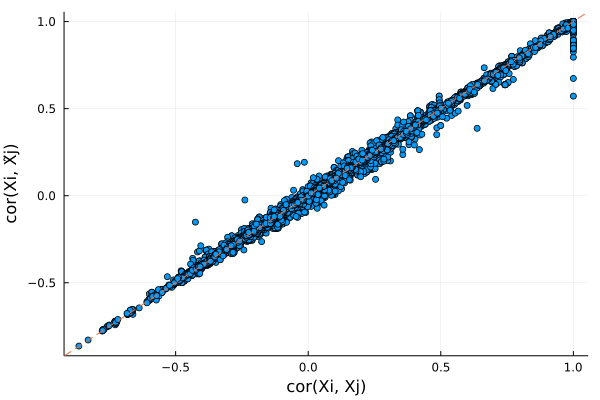

In [4]:
# look at only pairwise correlation between first 200 snps
r1, r2 = compare_pairwise_correlation(X, X̃, snps=200)

# make plot
scatter(r1, r2, xlabel = "cor(Xi, Xj)", ylabel="cor(Xi, X̃j)", legend=false)
Plots.abline!(1, 0, line=:dash)

Plots distribution of $cor(X_j, \tilde{X}_j)$ for all $j$. Ideally, we want $cor(X_j, \tilde{X}_j)$ to be small in magnitude (i.e. $X$ and $\tilde{X}$ is very different).

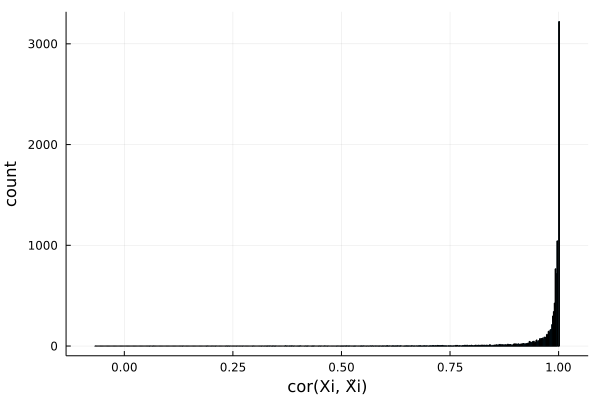

In [5]:
r2 = compare_correlation(X, X̃)
histogram(r2, legend=false, xlabel="cor(Xi, X̃i)", ylabel="count")